# 사전 학습된 ConvNet을 이용한 전이 학습
# tensorflowr -> pytorch


이 튜토리얼에서는 사전 훈련된 네트워크에서 전이 학습을 사용하여 고양이와 개의 이미지를 분류하는 방법을 배우게 됩니다.

사전 훈련된 모델은 이전에 대규모 데이터셋에서 훈련된 저장된 네트워크로, 일반적으로 대규모 이미지 분류 작업에서 훈련된 것입니다. 사전 훈련된 모델을 그대로 사용하거나 전이 학습을 사용하여 이 모델을 주어진 작업으로 사용자 정의하세요.

이미지 분류를 위한 전이 학습을 직관적인 시각에서 바라보면 모델이 충분히 크고 일반적인 데이터 집합에서 훈련된다면, 이 모델은 사실상 시각 세계의 일반적인 모델로서 기능할 것이라는 점입니다. 그런 다음 대규모 데이터셋에서 대규모 모델을 교육하여 처음부터 시작할 필요 없이 이러한 학습된 특징 맵을 활용할 수 있습니다.

이번 notebook에서는 사전 훈련된 모델을 사용자 정의하는 두 가지 방법을 시도 해보겠습니다.:

1. 특성 추출: 새 샘플에서 의미 있는 특성을 추출하기 위해 이전 네트워크에서 학습한 표현을 사용합니다. 사전 훈련된 모델 위에 처음부터 훈련할 새 분류자를 추가하기만 하면 이전에 데이터세트로 학습한 특성 맵의 용도를 재사용할 수 있습니다.

전체 모델을 재훈련시킬 필요는 없습니다. 기본 컨볼루션 네트워크에는 그림 분류에 일반적으로 유용한 기능이 이미 포함되어 있습니다. 그러나 사전 훈련된 모델의 최종 분류 부분은 기존의 분류 작업에 따라 다르며 이후에 모델이 훈련된 클래스 집합에 따라 다릅니다.

1. 미세 조정: 고정된 기본 모델의 일부 최상위 층을 고정 해제하고 새로 추가 된 분류기 층과 기본 모델의 마지막 층을 함께 훈련시킵니다. 이를 통해 기본 모델에서 고차원 특징 표현을 "미세 조정"하여 특정 작업에 보다 관련성이 있도록 할 수 있습니다.

일반적인 기계 학습 일련의 과정을 진행합니다.

1. 데이터 검사 및 이해
2. 입력 파이프 라인 빌드(이 경우 Keras ImageDataGenerator를 사용)
3. 모델 작성
    - 사전 훈련된 기본 모델(또한 사전 훈련된 가중치)에 적재
    - 분류 레이어를 맨 위에 쌓기
4. 모델 훈련
5. 모델 평가


In [1]:
import os
import zipfile
import urllib.request
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import transforms, datasets, models

## 데이터 전처리

### 데이터 다운로드

이 튜토리얼에서는 수천 개의 고양이와 개의 이미지가 포함된 데이터세트를 사용합니다. 이미지가 포함된 zip 파일을 다운로드하여 추출은 다음 `tf.keras.utils.image_dataset_from_directory` 유틸리티를 사용하여 훈련 및 검증을 위한 `tf.data.Dataset`를 생성합니다. 이 [튜토리얼](https://www.tensorflow.org/tutorials/load_data/images)에서 이미지 로드에 대해 자세히 알아볼 수 있습니다.

In [2]:
# 1. 데이터셋 다운로드 및 압축 해제 (이미 다운로드된 경우 건너뜁니다)
url = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_filename = 'cats_and_dogs_filtered.zip'
if not os.path.exists('cats_and_dogs_filtered'):
    print("Downloading dataset...")
    urllib.request.urlretrieve(url, zip_filename)
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall('.')
    print("Dataset downloaded and extracted.")

Dataset downloaded and extracted.


In [3]:
# 2. 경로 설정
BASE_DIR = os.path.join(os.getcwd(), 'cats_and_dogs_filtered')
train_dir = os.path.join(BASE_DIR, 'train')
validation_dir = os.path.join(BASE_DIR, 'validation')

In [4]:
# 3. 하이퍼파라미터 설정
BATCH_SIZE = 32
IMG_SIZE = (160, 160)  # (height, width)
base_learning_rate = 0.0001
initial_epochs = 10
fine_tune_epochs = 10

In [5]:
# 4. 데이터 전처리 및 데이터 증강
# TF 코드에서는 RandomFlip, RandomRotation을 별도 레이어로 사용합니다.
# 여기서는 transforms를 이용하여 이미지 증강 및 전처리 수행합니다.
# MobileNetV2의 TF preprocess_input는 [0,255] -> [-1,1] 변환을 수행하므로,
# ToTensor() 후 Normalize(mean=0.5, std=0.5)로 동일 효과를 줍니다.

train_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    # tf.keras.layers.RandomRotation(0.2)는 약 ±72도 회전 효과를 줍니다.
    transforms.RandomRotation(72),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

val_transforms = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [6]:
# 5. 데이터셋 로드 (ImageFolder를 이용)
train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transforms)
val_full_dataset = datasets.ImageFolder(root=validation_dir, transform=val_transforms)
class_names = train_dataset.classes
print("클래스 이름:", class_names)

클래스 이름: ['cats', 'dogs']


In [7]:
# 6. validation 데이터셋의 1/5을 test 데이터셋으로 분리
val_total = len(val_full_dataset)
test_size = val_total // 5
val_size = val_total - test_size
validation_dataset, test_dataset = random_split(val_full_dataset, [val_size, test_size])

In [8]:
# 7. DataLoader 생성
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print("Number of validation batches: %d" % len(val_loader))
print("Number of test batches: %d" % len(test_loader))

Number of validation batches: 25
Number of test batches: 7


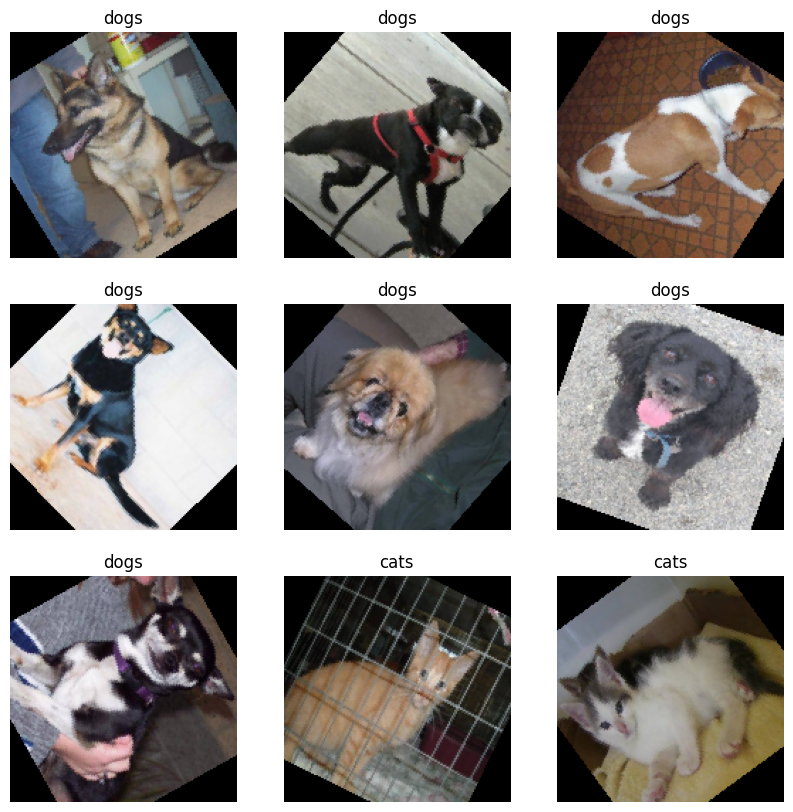

In [9]:
# 8. 학습 데이터에서 일부 이미지 시각화
def imshow(inp, title=None):
    """Tensor 이미지 출력 함수 ([-1,1] 범위를 [0,1]로 변환)"""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    inp = np.clip((inp * 0.5) + 0.5, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

dataiter = iter(train_loader)
images, labels = next(dataiter)
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    imshow(images[i], title=class_names[labels[i]])
plt.show()

In [10]:
# 9. 모델 구성: MobileNetV2 기반 전이 학습
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# pretrained=True이면 ImageNet 가중치 로드
model = models.mobilenet_v2(pretrained=True)
# 기존 classifier를 binary classification용으로 재정의 (출력: 1)
model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(model.last_channel, 1)
)
model = model.to(device)

c:\Users\user\anaconda3\envs\supernova\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\user\anaconda3\envs\supernova\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to C:\Users\user/.cache\torch\hub\checkpoints\mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 63.0MB/s]


In [11]:
# 10. 초기 학습 단계에서는 base_model(즉, features 부분)은 고정하고 classifier만 학습
for param in model.features.parameters():
    param.requires_grad = False

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=base_learning_rate)

In [12]:
# 11. 평가 함수 정의
def evaluate(model, dataloader):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            # labels: [batch] -> [batch, 1] (float)
            labels = labels.to(device).float().unsqueeze(1)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            running_corrects += torch.sum(preds == labels)
            total += inputs.size(0)
    epoch_loss = running_loss / total
    epoch_acc = running_corrects.double() / total
    return epoch_loss, epoch_acc.item()

loss0, accuracy0 = evaluate(model, val_loader)
print("Initial validation loss: {:.2f}".format(loss0))
print("Initial validation accuracy: {:.2f}".format(accuracy0))

Initial validation loss: 0.83
Initial validation accuracy: 0.42


In [13]:
# 12. 학습 루프 함수 정의
def train_model(model, dataloader, optimizer, criterion, num_epochs, val_loader=None):
    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            preds = (torch.sigmoid(outputs) >= 0.5).float()
            running_corrects += torch.sum(preds == labels)
            total += inputs.size(0)
        epoch_loss = running_loss / total
        epoch_acc = running_corrects.double() / total
        train_loss_history.append(epoch_loss)
        train_acc_history.append(epoch_acc.item())
        if val_loader:
            val_loss, val_acc = evaluate(model, val_loader)
            val_loss_history.append(val_loss)
            val_acc_history.append(val_acc)
            print(f"Epoch {epoch+1}/{num_epochs} -- Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, " +
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        else:
            print(f"Epoch {epoch+1}/{num_epochs} -- Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}")
    return train_loss_history, train_acc_history, val_loss_history, val_acc_history

In [14]:
# 13. 초기 학습: classifier만 학습 (initial_epochs)
print("\n----- Initial Training -----")
train_loss_hist, train_acc_hist, val_loss_hist, val_acc_hist = train_model(
    model, train_loader, optimizer, criterion, initial_epochs, val_loader)


----- Initial Training -----
Epoch 1/10 -- Train Loss: 0.6753, Train Acc: 0.5805, Val Loss: 0.5710, Val Acc: 0.8013
Epoch 2/10 -- Train Loss: 0.5820, Train Acc: 0.7320, Val Loss: 0.4804, Val Acc: 0.8688
Epoch 3/10 -- Train Loss: 0.5141, Train Acc: 0.7950, Val Loss: 0.4115, Val Acc: 0.8988
Epoch 4/10 -- Train Loss: 0.4697, Train Acc: 0.8265, Val Loss: 0.3798, Val Acc: 0.9038
Epoch 5/10 -- Train Loss: 0.4369, Train Acc: 0.8395, Val Loss: 0.3419, Val Acc: 0.9175
Epoch 6/10 -- Train Loss: 0.4051, Train Acc: 0.8540, Val Loss: 0.3172, Val Acc: 0.9188
Epoch 7/10 -- Train Loss: 0.3922, Train Acc: 0.8600, Val Loss: 0.3020, Val Acc: 0.9200
Epoch 8/10 -- Train Loss: 0.3851, Train Acc: 0.8475, Val Loss: 0.2787, Val Acc: 0.9287
Epoch 9/10 -- Train Loss: 0.3656, Train Acc: 0.8595, Val Loss: 0.2719, Val Acc: 0.9300
Epoch 10/10 -- Train Loss: 0.3504, Train Acc: 0.8695, Val Loss: 0.2561, Val Acc: 0.9250


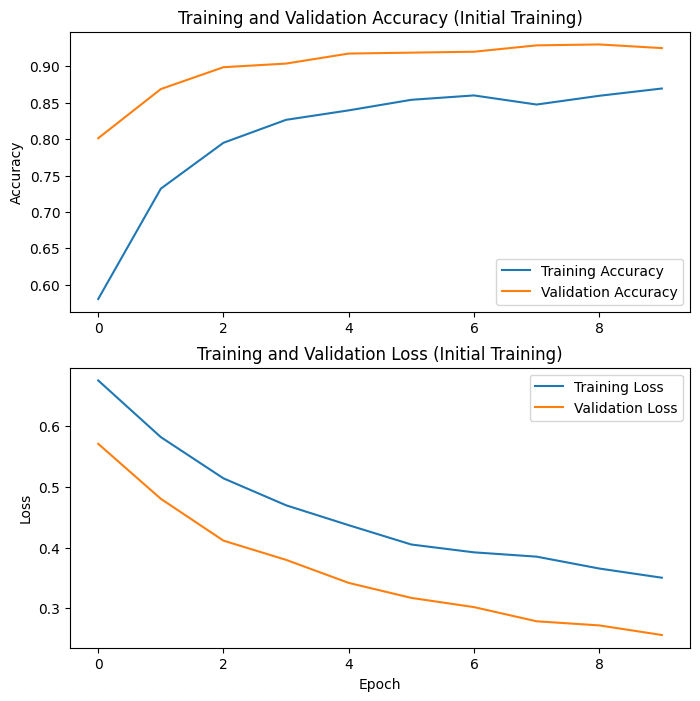

In [15]:
# 14. 학습 결과 시각화 (초기 단계)
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(train_acc_hist, label='Training Accuracy')
plt.plot(val_acc_hist, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy (Initial Training)')
plt.legend(loc='lower right')

plt.subplot(2,1,2)
plt.plot(train_loss_hist, label='Training Loss')
plt.plot(val_loss_hist, label='Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss (Initial Training)')
plt.legend(loc='upper right')
plt.show()

In [16]:
# 15. 파인튜닝 단계: base_model의 일부 layer를 unfreeze
# 여기서는 mobilenet_v2의 features 모듈 내에서 인덱스 10 이후의 블록을 unfreeze하도록 합니다.
fine_tune_at = 10  # (모듈 인덱스, 필요에 따라 조정)
for idx, layer in enumerate(model.features):
    if idx < fine_tune_at:
        for param in layer.parameters():
            param.requires_grad = False
    else:
        for param in layer.parameters():
            param.requires_grad = True

# 파인튜닝 시에는 학습률을 낮춥니다.
optimizer_ft = optim.RMSprop(filter(lambda p: p.requires_grad, model.parameters()), lr=base_learning_rate/10)

In [17]:
# 16. 파인튜닝 학습 (fine_tune_epochs)
print("\n----- Fine-Tuning -----")
train_loss_hist_ft, train_acc_hist_ft, val_loss_hist_ft, val_acc_hist_ft = train_model(
    model, train_loader, optimizer_ft, criterion, fine_tune_epochs, val_loader)

# 전체 학습 이력 합치기
total_train_acc = train_acc_hist + train_acc_hist_ft
total_val_acc = val_acc_hist + val_acc_hist_ft
total_train_loss = train_loss_hist + train_loss_hist_ft
total_val_loss = val_loss_hist + val_loss_hist_ft


----- Fine-Tuning -----
Epoch 1/10 -- Train Loss: 0.2674, Train Acc: 0.8960, Val Loss: 0.1481, Val Acc: 0.9537
Epoch 2/10 -- Train Loss: 0.2066, Train Acc: 0.9165, Val Loss: 0.1311, Val Acc: 0.9563
Epoch 3/10 -- Train Loss: 0.2037, Train Acc: 0.9180, Val Loss: 0.1245, Val Acc: 0.9575
Epoch 4/10 -- Train Loss: 0.1880, Train Acc: 0.9255, Val Loss: 0.1198, Val Acc: 0.9625
Epoch 5/10 -- Train Loss: 0.1670, Train Acc: 0.9320, Val Loss: 0.1115, Val Acc: 0.9600
Epoch 6/10 -- Train Loss: 0.1467, Train Acc: 0.9385, Val Loss: 0.1083, Val Acc: 0.9625
Epoch 7/10 -- Train Loss: 0.1383, Train Acc: 0.9530, Val Loss: 0.1093, Val Acc: 0.9637
Epoch 8/10 -- Train Loss: 0.1515, Train Acc: 0.9375, Val Loss: 0.0996, Val Acc: 0.9688
Epoch 9/10 -- Train Loss: 0.1384, Train Acc: 0.9460, Val Loss: 0.1029, Val Acc: 0.9663
Epoch 10/10 -- Train Loss: 0.1371, Train Acc: 0.9495, Val Loss: 0.1036, Val Acc: 0.9675


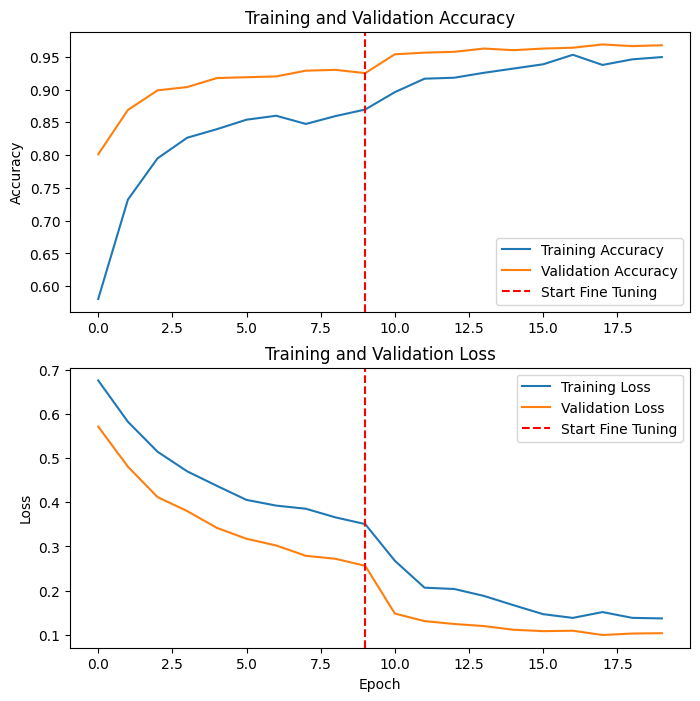

In [18]:
# 17. 전체 학습 결과 시각화
plt.figure(figsize=(8,8))
plt.subplot(2,1,1)
plt.plot(total_train_acc, label='Training Accuracy')
plt.plot(total_val_acc, label='Validation Accuracy')
plt.axvline(x=initial_epochs-1, color='r', linestyle='--', label='Start Fine Tuning')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend(loc='lower right')

plt.subplot(2,1,2)
plt.plot(total_train_loss, label='Training Loss')
plt.plot(total_val_loss, label='Validation Loss')
plt.axvline(x=initial_epochs-1, color='r', linestyle='--', label='Start Fine Tuning')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Training and Validation Loss')
plt.legend(loc='upper right')
plt.show()

In [19]:
# 18. 테스트 데이터셋 평가
test_loss, test_acc = evaluate(model, test_loader)
print("Test accuracy: {:.4f}".format(test_acc))

Test accuracy: 0.9700


Predictions:
 [0 1 0 1 0 0 0 0 0 1 1 1 1 0 0 1 1 0 1 1 1 0 0 1 0 0 0 0 0 1 0 1]
Labels:
 [0 1 0 1 0 0 0 0 1 1 1 1 1 0 0 1 1 0 1 1 1 0 0 1 1 0 0 0 0 1 0 1]


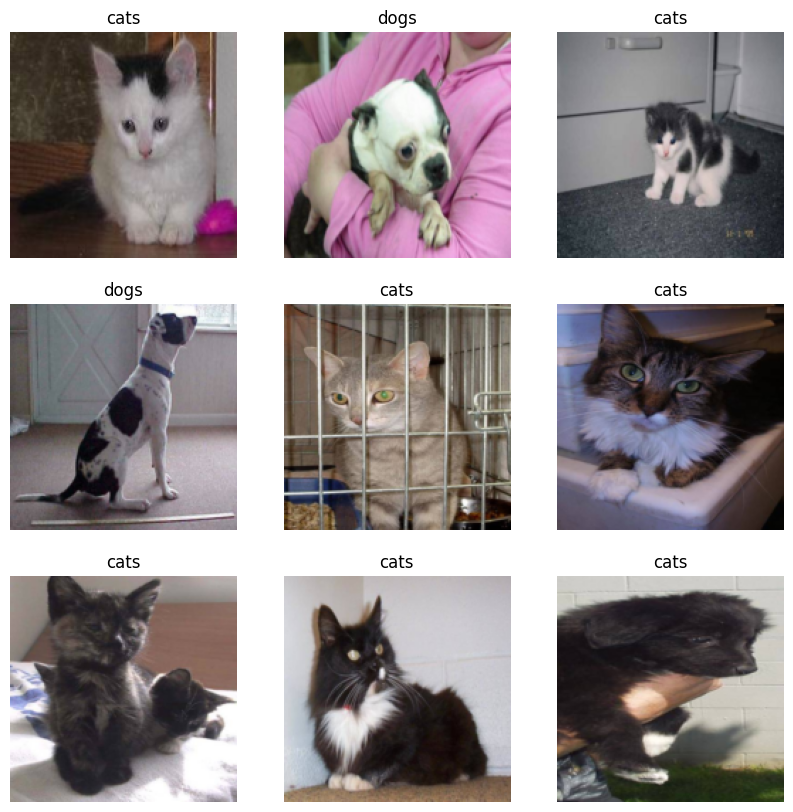

In [20]:
# 19. 테스트 배치에 대해 예측 수행 및 결과 시각화
model.eval()
dataiter = iter(test_loader)
images, labels = next(dataiter)
images = images.to(device)
outputs = model(images)
preds = (torch.sigmoid(outputs) >= 0.5).float().cpu().numpy().astype(int).flatten()
print('Predictions:\n', preds)
print('Labels:\n', labels.numpy())

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    # 이미지 복원: [-1,1] -> [0,1]
    img = images[i].cpu().permute(1, 2, 0).numpy()
    img = np.clip((img * 0.5) + 0.5, 0, 1)
    plt.imshow(img)
    plt.title(class_names[preds[i]])
    plt.axis('off')
plt.show()

## 요약:

- **특징 추출을 위해 사전 훈련된 모델 사용하기**:  작은 데이터셋으로 작업 할 때는 동일한 범주의 클래스의 더 큰 데이터셋으로 훈련시킨 사전 학습된 모델의 특징을 활용하는 것이 일반적입니다. 사전 훈련된 모델을 인스턴스화하고 완전히 연결된 분류기를 맨 위에 추가하면 됩니다. 사전 훈련된 모델은 "고정"되고 분류기의 가중치만 훈련 중에 업데이트됩니다. 이 경우 컨벌루션 베이스 모델은 각 이미지와 관련된 모든 특징을 추출하며 주어진 추출된 특징을 가지고 이미지 클래스를 결정하는 분류기를 훈련합니다.

- **사전 훈련된 모델을 미세 조정하기**: 성능을 더욱 향상시키기 위해 사전 훈련된 모델의 최상위 계층을 미세 조정을 통해 새 데이터셋으로써 재사용 할 수 있습니다. 이 경우 모델이 주어진 데이터셋에 맞는 상위 레벨의 특징을 학습 할 수 있도록 가중치를 조정합니다. 이 기술은 일반적으로 훈련 데이터셋의 규모가 크고, 사전 훈련된 모델이 사용했던 원래 데이터셋과 매우 유사한 경우에 권장됩니다.

자세한 내용은 [전이 학습 가이드](https://www.tensorflow.org/guide/keras/transfer_learning)를 참조하십시오.
